In [1]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

### Setup the notebook.

In [2]:
import h5py
import math
testNames=["first_order_reversible_time_limit"]
test_names_bash_list=" ".join(testNames)
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [3]:
%%bash
rm -rf tmp && mkdir tmp

### Execute the simulations.

In [4]:
%%bash -s "$test_names_bash_list"
sbmlFilename="first_order_reversible.sbml"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    rm -f ${outputFilename}* && lm_sbml_import ${outputFilename} ${sbmlFilename} > ${outputFilename}.import.log
    if [ ${testName} == "first_order_reversible_time_limit" ]; then
        lm_setp ${outputFilename} writeInterval=1e-3 maxTime=2e0 > /dev/null
    else
        echo "Invalid test name: ${testName}"
    fi
    lmes -r 1-1000 -f ${outputFilename} > ${outputFilename}.simulate.log
done;
echo "Finished."

Finished.


### Do some consistency checks

In [5]:
# make sure that there are maxTime/writeInterval + 1 == 2001 entries in the output from each replicate
import h5py
import os
for testName in testNames:
    with h5py.File(os.path.join('tmp', testName + '.lm'), mode='r') as f:
        for group in f['Simulations'].values():
            datasetCount = 0
            for dataset in group.values():
                datasetCount += 1
                assert dataset.shape[0]==2001
            assert datasetCount==2

### Spot check some simulations.

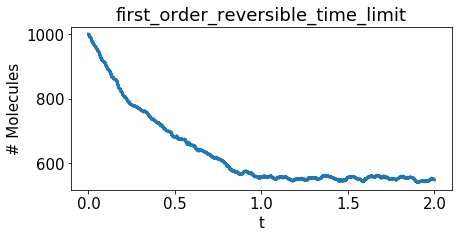

In [6]:
# Plot the time series for a single replicate.
for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
    fp = h5py.File(testOutputFilename, "r")
    cols=2
    rows=len(testNames)/cols+1
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,2*rows)})
    for replicate in (1,):
        counts=np.array(fp["/Simulations/%07d/SpeciesCounts"%replicate], dtype=double)
        times=np.array(fp["/Simulations/%07d/SpeciesCountTimes"%replicate], dtype=double)
        plt.subplot(rows,cols,i+1)
        step(times,counts[:,0], **stepStyles)
        xlabel('t'); ylabel('# Molecules'); title("%s"%(testName))
    fp.close()
pass

### Define the tests.

In [7]:
def test_first_order_reversible_time_limit(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    for replicate in replicates:
        if times is None:
            times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        if mSim is None:
            k += 1
            mSim = counts
            vSim = np.zeros(counts.shape, dtype=double)
        else:
            k += 1
            mSim = mSim + (counts-mSim)/k
            vSim = vSim + (counts-mSim)*(counts-mSim)
    vSim /= float((k-1))

    A0=mSim[0,0]
    k1=1.0
    k2=1.0
    k=k1+k2
    lam=k1/k2
    ome=lam*exp(-k*times)+1
    mTheory=(A0/k)*(k1*exp(-k*times)+k2)
    vTheory=((A0*ome)/(1+lam))*(1-(ome/(1+lam)))

    # Plot the accuracy of the mean and variance.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,6)})
    ax=plt.subplot(2,2,1)
    plt.plot(times,mSim[:,0], **plotStyles)
    plt.plot(times,mTheory, **plotStyles)
    ax.set_yscale('linear'); xlabel('t'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,2,2)
    plt.plot(times,abs(mSim[:,0]-mTheory)/mTheory, **plotStyles)
    ax.set_yscale('log'); ylim([1e-6,1e-2]); xlabel('t'); ylabel('Relative Error'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,2,3)
    plt.plot(times,vSim[:,0], **plotStyles)
    plt.plot(times,vTheory, **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('Var{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,2,4)
    plt.plot(times,abs(vSim[:,0]-vTheory)/vTheory, **plotStyles)
    ax.set_yscale('log'); ylim([1e-6,1e-0]); xlabel('t'); ylabel('Relative Error'); title("%s"%(testOutputFilename))
    fp.close()

    value = np.max(abs(mSim[:,0]-mTheory)/mTheory)
    if value > 3e-3: raise Exception("max error in mean too large",value)
    value = np.mean(abs(mSim[:,0]-mTheory)/mTheory)
    if value > 1e-3: raise Exception("mean error in mean too large",value)
    value = np.max(abs(vSim[1:,0]-vTheory[1:])/vTheory[1:])
    if value > 2e-1: raise Exception("max error in variance too large",value)       

### Run the tests.

[first_order_reversible_time_limit]                          : passed.


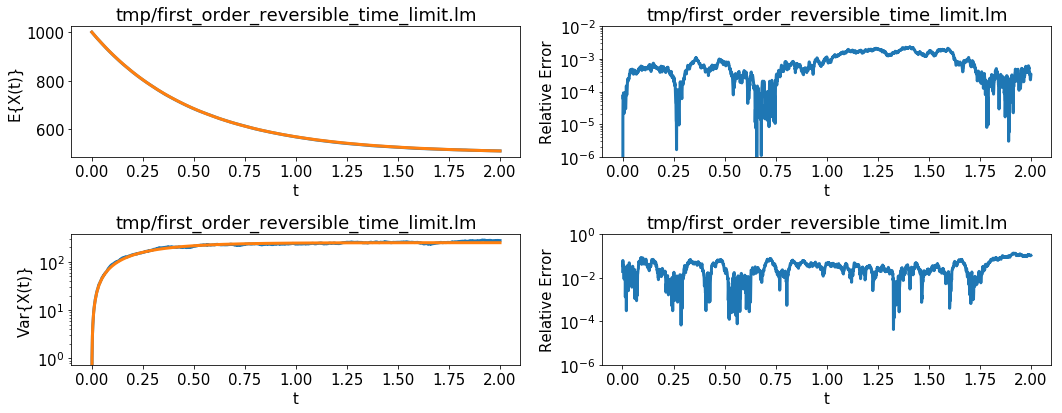

In [8]:
testMethods = {"first_order_reversible_time_limit": test_first_order_reversible_time_limit}
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5*len(testNames))})
i=1
for testName in testNames:
    try:
        testOutputFilename="tmp/%s.lm"%(testName)
        testMethods[testName](testOutputFilename)
    except Exception as e:
        print "%-60s : FAILED with:"%("["+testName+"]"),e
    except:
        print "%-60s : FAILED with: Unknown exception"%("["+testName+"]")
    else:
        print "%-60s : passed."%("["+testName+"]")
    plt.tight_layout()
    plt.show()
pass

In [9]:
%%bash
rm -rf tmp